***Dr. Emmanuel Dufourq*** www.emmanueldufourq.com

***African Institute for Mathematical Sciences***

***2019***


Credits: The data imports and architecture were extracted from https://keras.rstudio.com/articles/examples/imdb_cnn.html

***NOTE***

Be sure to use hardware acceleration to use the GPU. Click on `Runtime`, change `runtime type`, and select `GPU` for the *hardware accelerator* option.

In [1]:
devtools::install_github("rstudio/keras")

Skipping install of 'keras' from a github remote, the SHA1 (34dc89ed) has not changed since last install.
  Use `force = TRUE` to force installation


## Import the Keras library

In [0]:
library(keras)
library(stringr)

## Load the IMDB dataset

Here we load the IMDB dataset and specify that we want the top 10,000 most frequent words. Which which occur less frequently than the top 10,000 will be discarded. 

In practice we can also use other techniques such as stop-word removal and tf-idf to get rid of certain "rare" words which don't add much value to the classification process.

_***Loading this data set can take a minute or two***_

In [0]:
imdb <- dataset_imdb(num_words = 10000)

### Take a look at the first data point

This data point has a length of 218

In [4]:
str(imdb$train$x[1])

List of 1
 $ : int [1:218] 1 14 22 16 43 530 973 1622 1385 65 ...


### Take a look at another data point

This data point has a length of 130

In [5]:
str(imdb$train$x[10])

List of 1
 $ : int [1:130] 1 14 20 47 111 439 3445 19 12 15 ...


## Padding

The neural network approach we will use requires that the input is of fixed size. So we cannot use the data in it's current form as each text extract (data point) is a different length. We can fix this by padding the sentences with zeros. Padding is added to the left. To pad we need to specify a maximum length. Each data point which had less words than the maximum length will be padded with zeros so that it reaches the correct length.

In this case we choose the maximum data point length to be 400.

In [0]:
x_train <- imdb$train$x %>% pad_sequences(maxlen = 400)
x_test <- imdb$test$x %>% pad_sequences(maxlen = 400)

## Check the dimensions to verify that padding was performed

In [7]:
dim(x_train)

[1] 25000   400

In [8]:
dim(x_test)

[1] 25000   400

## Compare

Now compare the output above to this one below. This is the 10th data point. Notice the sequence 1, 14, 20 ,47 has been padded with zeros?

In [9]:
x_train[10,]

[1]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 [16]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 [31]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 [46]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 [61]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 [76]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 [91]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
[106]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
[121]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
[136]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
[151]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
[166]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
[181]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
[196]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
[211]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
[226]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
[241]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
[256]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
[271]    1   14   20   47  111  439 3445   19   12   15  166   12  216  125   40
[286]    6  364  352  707 1187   39  294   11   22  396   13   28    8  202   12
[301] 1109   23   94    2  151  111  211  469    4   20   13  258  546 1104 7273
[316]   12   16   38   78   33  211   15   12   16 2849   63   93   12    6  253
[331]  106   10   10   48  335  267   18    6  364 1242 1179   20   19    6 1009
[346]    7 1987  189    5    6 8419    7 2723    2   95 1719    6 6035    7 3912
[361] 7144   49  369  120    5   28   49  253   10   10   13 1041   19   85  795
[376]   15    4  481    9   55   78  807    9  375    8 1167    8  794   76    7
[391]    4   58    5    4  816    9  243    7   43   50

### Assign the target values

In [0]:
y_train = imdb$train$y
y_test = imdb$test$y

### Take a look at the target values

This is a binary classification problem (2 classes). 

We can either use a sigmoid function in the last layer in which case we do not need to conver the target values. Alternatively, we can convert the values to their one-hot encoded corresponding values in which case we would need to use the softmax function in the last layer.

In [11]:
str(y_train[0:5])

 int [1:5] 1 0 0 1 0


## Create a model

In [0]:
model <- keras_model_sequential() %>%
  layer_embedding(input_dim = 10000, output_dim = 32, input_length = 400) %>% #embedding layer
  layer_dropout(0.2) %>%
  layer_conv_1d(filters = 32, kernel_size = 3, padding = "valid", activation = "relu", strides = 1) %>%
  layer_global_max_pooling_1d() %>%
  layer_dense(units = 128, activation = 'relu') %>% # the MLP starts here
  layer_dropout(rate = 0.5) %>% 
  layer_dense(units = 1, activation = 'sigmoid')

## Compile the model

In [0]:
model %>% compile(
  loss = "binary_crossentropy",
  optimizer = "adam",
  metrics = "accuracy"
)

## Note the output of 1-D global max pooling

Here, for each of the 100 embedding vectors, the maximum value is computed. In this example, there are 100 embedding vectors of length 398, and thus the maximum value is extracted resulting in a shape of (None, 100).

In [48]:
summary(model)

Model: "sequential_4"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
embedding_4 (Embedding)             (None, 400, 32)                 320000      
________________________________________________________________________________
dropout_8 (Dropout)                 (None, 400, 32)                 0           
________________________________________________________________________________
conv1d_4 (Conv1D)                   (None, 398, 32)                 3104        
________________________________________________________________________________
global_max_pooling1d_4 (GlobalMaxPo (None, 32)                      0           
________________________________________________________________________________
dense_8 (Dense)                     (None, 128)                     4224        
________________________________________________________________________________
dropou

## Train the model

This takes about 1 minute to train on the GPU instance using 4 epochs

In [0]:
history <- model %>% fit(
  x_train,
  y_train,
  epochs = 3,
  validation_split = 0.2,
  verbose = 0,
  batch_size = 16
)

### Plot the performance

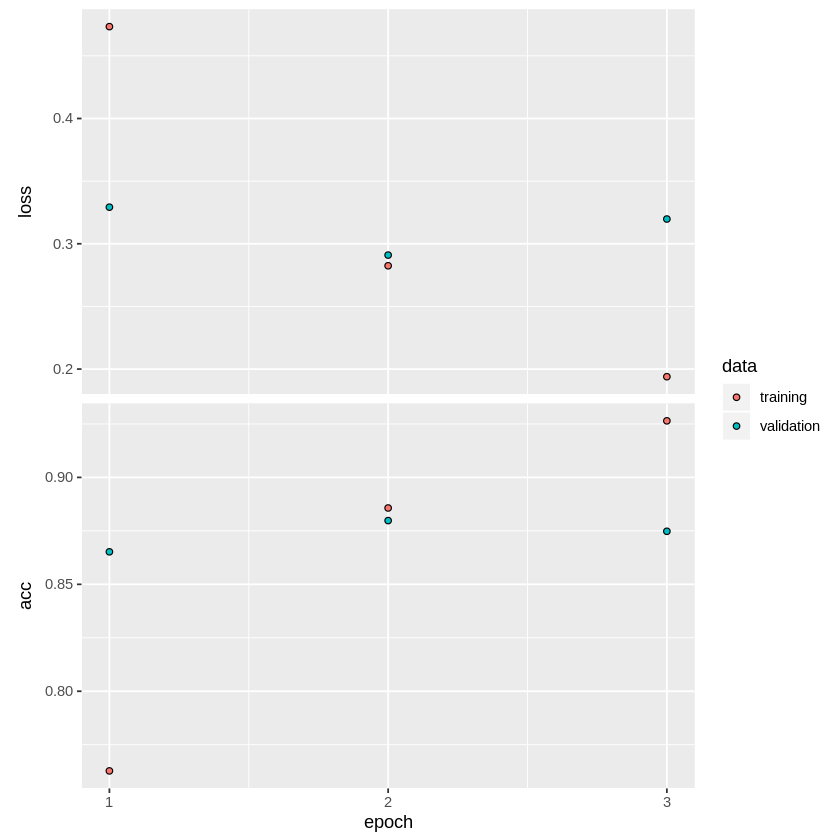

In [50]:
plot(history)

## Evaluate the performance

In [51]:
model %>% evaluate(x_test, y_test)

$loss
[1] 0.3224809

$acc
[1] 0.87104

## Predicting

We can obtain the sigmoid outputs for each test case.

In [23]:
model %>% predict(x_test[1:10,])

2.763301e-03
9.995775e-01
3.021270e-03
9.325276e-01
9.991452e-01
6.911783e-01
3.939599e-03
2.771616e-05
9.853506e-01
9.308123e-01


Using the `predict_classes` function we can get the binary predictions for each test case.

In [28]:
model %>% predict_classes(x_test[1:10,])

0
1
0
1
1
1
0
0
1
1
